In [ ]:
!pip install --upgrade mesa
!pip install --upgrade networkx[default]

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mesa
import networkx as nx

In [41]:
df = pd.read_csv('data/20230413_clb_taps.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
entry_df = df.set_index('Datetime')
entry_df = entry_df[entry_df['Direction']=='Entry']['Direction'].resample('10min',  label='left').count().reset_index()

In [42]:
entry_df

,Datetime,Direction
0,2023-04-12 22:50:00+00:00,1
1,2023-04-12 23:00:00+00:00,0
2,2023-04-12 23:10:00+00:00,0
3,2023-04-12 23:20:00+00:00,3
4,2023-04-12 23:30:00+00:00,3
...,...,...
79,2023-04-13 12:00:00+00:00,13
80,2023-04-13 12:10:00+00:00,22
81,2023-04-13 12:20:00+00:00,13
82,2023-04-13 12:30:00+00:00,18


## Agent-Based Model

In [164]:
class LibAgent(mesa.Agent):
    """An agent representing library user"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.timesteps = np.random.uniform(1,20) # time spent studying in library
        self.timesteps = np.random.normal(10,0) # time spent studying in library

    def step(self):
        if self.timesteps > 0:
            self.timesteps -= 1
        else:
            self.model.schedule.remove(self)
            # TODO: remove from grid/network

In [160]:
def compute_agents(model):
    return len(model.schedule.agents)

class LibModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, entry_df):
        self.schedule = mesa.time.RandomActivation(self)
        self._curr_step = 0
        self.entry_dist = entry_df.to_dict()['Direction']
        self.total_steps = len(self.entry_dist) # total steps taken
        self.datacollector = mesa.DataCollector(
            model_reporters={"num_agents": compute_agents},#  agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        # Create agents, where number of agents follows Poisson distribution
        num_agents = self.entry_dist[self._curr_step]
        for i in range(np.random.poisson(num_agents)):
            agent = LibAgent(f'{self._curr_step}-{i}', self)
            # print(agent.unique_id, 'created!') # for debugging
            self.schedule.add(agent) # add to schedule
        self.schedule.step()
        self._curr_step += 1

    def run(self):
        for i in range(self.total_steps):
            self.step()

<AxesSubplot: xlabel='Datetime', ylabel='num_agents'>

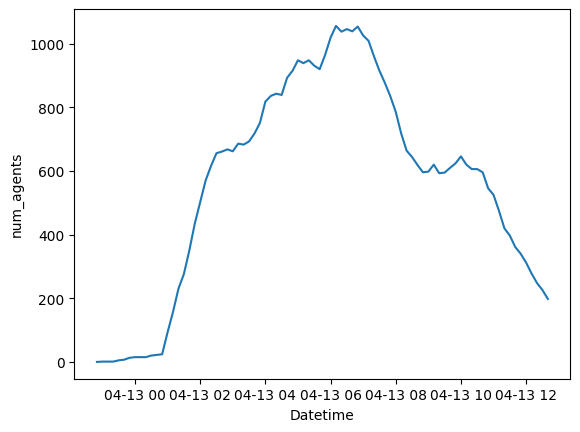

In [165]:
model = LibModel(entry_df)
model.run()
results = model.datacollector.get_model_vars_dataframe()
results['Datetime'] = entry_df['Datetime']
sns.lineplot(results, x='Datetime', y='num_agents')